# New York City Schools

## Context
One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. 

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points. Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

Given our prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) data on high school SAT scores available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2). The first few rows of the SAT data look like this:


![](Image.png)

## Read in the data
Unfortunately, combining both of the data sets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these data sets are interrelated. We'll need to combine them into a single data set before we can find correlations.

Some backgrounds research give us these informations:

* Only high school students take the SAT, so we'll want to focus on high schools. Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
* New York City is made up of five boroughs, which are essentially distinct regions.
* New York City schools fall within several different school districts, each of which can contains dozens of schools.
* Each school in New York City has a unique code called a DBN, or district borough number. So aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

Let's read the data

In [181]:
import pandas as pd
import numpy
import re

#List of the datasets names
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Dictionnary containing datasets name as key and the corresponding dataframe as value. 
data = {}

for f in data_files:
    d = pd.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

We read each file into a pandas dataframe, and then store all of the dataframes in a dictionary. This will give us a convenient way to store them, and a quick way to reference them later on

What we're mainly interested in is the SAT data set, which corresponds to the dictionary key *sat_results*. This data set contains the SAT scores for each high school in New York City. We eventually want to correlate selected information from this data set with information in the other data sets.

Let's explore sat_results to see what we can discover. Exploring the dataframe will help us understand the structure of the data, and make it easier for us to analyze it.

In [182]:
print(data["ap_2010"].head())

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  


We can tell from the first few rows of names that we only have data about high schools.The DBN appears to be a unique ID for each school.


We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.
Given these observations, let's explore the other data sets to see if we can gain any insight into how to combine them.

In [183]:
start="\033[1m" # start bold
end="\033[0m"# end bolt
for dataset in data:
    print("\n \n"+ start +' FIRST FIVE ROWS OF {} DATASET '.format(dataset).center(70,"-") + end + "\n")
    print(data[dataset].head())


 
----------------- FIRST FIVE ROWS OF ap_2010 DATASET -----------------

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  

 
--------------- FIRST FIVE ROWS OF class_size DATASET ----------------

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM 

Each dataset appears to either have a DBN column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBN, then group all of their columns together in a single data set.

Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.

Some of the data sets appear to contain multiple rows for each school. We’ll have to do some preprocessing to ensure that each DBN is unique within each data set.

But before that, let's deal with surveys files.

## Read in the Surveys

The two survey files are "survey_all.txt" and "survey_d75.txt". The files are tab delimited and encoded with Windows-1252 encoding. Let's concatenate both datasets in one dataframe called survey and let's take only the columns we need. These columns are in blue in the preview of the data dictionary below.

![](Image2.png)

These columns will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It will also give us the DBN, which allows us to uniquely identify the school.

Finally we had the "survey" dataframe to the data dictionary.

In [322]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0,sort=True)

survey["DBN"] = survey["dbn"] # Renaming the column "dbn" by "DBN"

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey # Adding the dataframe survey to data dictionnary

When we explored all of the data sets, we noticed that some of them, like *class_size* and *hs_directory*, don't have a DBN column. *hs_directory* does have a *dbn* column, though, so we can just rename it.

However, class_size doesn't appear to have the column DBN at all. Here are the first few rows of the data set:
![](class_size.png)

Here are the first few rows of the sat_results data, which does have a DBN column:

![](sat_results.png)

we notice that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. So we can create an explicit DBN column in the class_size data by combining CSD and *SCHOOL CODE* columns. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading <font color='red'>0</font> to the CSD if the CSD is less than two digits long.

# Add DBN columns

In [185]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"] #Renaming column name

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]


# Convert column to numeric

A column that totals up the SAT scores for the different sections of the exam will be useful in our analysis. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones(SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg).

Before we can generate this column, we'll need to convert the SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns in the sat_results data set from the object (string) data type to a numeric data type. 

It's important to pass the keyword argument errors="coerce" when we call pandas.to_numeric(), so that pandas treats any invalid strings it can't convert to numbers as missing values instead.

After we perform the conversion, we can use the addition operator (+) to add all three columns together.

In [186]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]



Next, we want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory dataset.

Let's take a look at the first few rows:

![](Location1.png)

As you can see, this field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field:

![](Locationbis.png)

We want to extract the latitude, 40.8276026690005, and the longitude, -73.90447525699966. Taken together, latitude and longitude make up a pair of coordinates that allows us to pinpoint any location on Earth.

We can do the extraction with a regular expression. The following expression will pull out everything inside the parentheses:

![](re.png)

This command will return [(40.8276026690005, -73.90447525699966)]

In [187]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

print(data["hs_directory"][["lat","lon"]].head())



         lat        lon
0  40.670299 -73.961648
1  40.827603 -73.904475
2  40.842414 -73.916162
3  40.710679 -74.000807
4  40.718810 -73.806500


Above is how hour latitude and longitude data look like from now on. 

# Condense datasets

Previously we noticed that the values in the DBN column were unique in the sat_results data set. Other datasets like class_size, graduation, and demographics have duplicate DBN values, however.We'll need to condense these datasets so that each value in the DBN column is unique. If not, we'll run into issues when it comes time to combine the data sets.

### Class_size

The first data set that we'll condense is class_size. The first few rows of class_size look like this:


In [188]:
print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


As you can see, the first few rows all pertain to the same school, which is why the DBN appears more than once. It looks like each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY).
If we look at the unique values for GRADE, we get the following:

In [189]:
print(data["class_size"]["GRADE "].unique())

['0K' '01' '02' '03' '04' '05' '0K-09' nan '06' '07' '08' 'MS Core'
 '09-12' '09']


Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.

If we look at the unique values for PROGRAM TYPE, we get the following:

In [190]:
print(data["class_size"]["PROGRAM TYPE"].unique(),"\n\n",data["class_size"]["PROGRAM TYPE"].describe())

['GEN ED' 'CTT' 'SPEC ED' nan 'G&T'] 

 count      26127
unique         4
top       GEN ED
freq       14545
Name: PROGRAM TYPE, dtype: object


Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.

In [191]:
#Selecting 09-12 grade and GEN ED program
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

When we display class_size after this filter, DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns. CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) seem to pertain to different kinds of classes. For example, here are the unique values for CORE SUBJECT (MS CORE and 9-12 ONLY):

In [192]:
print(class_size["CORE SUBJECT (MS CORE and 9-12 ONLY)"].unique())

['ENGLISH' 'MATH' 'SCIENCE' 'SOCIAL STUDIES']


This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.

In [210]:
#Finding the average values for each column associated with each DBN in class_size
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)

#Assigning class_size back to the class_size key of the data dictionary.
data["class_size"] = class_size 

print(data["class_size"].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

## demographics
Now let's condense demographics.
In this dataset, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

In [214]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

## graduation

Finally, we'll need to condense the graduation data set. The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [194]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

There are three columns we'll need to convert:

* AP Test Takers
* Total Exams Taken
* Number of Exams with scores 3 4 or 5

In [215]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

Because this project is concerned with determing demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from sat_results while minimizing null values.This means that we may need to use different merge strategies with different data sets. 

Some of the data sets have a lot of missing DBN values. This makes a left join more appropriate, because we don't want to lose too many rows when we merge. If we did an inner join, we would lose the data for many high schools.

Some data sets have DBN values that are almost identical to those in sat_results. Those data sets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from demographics, for example. Therefore, we'll do an inner join to avoid missing data in these columns.

The left joins will give us many columns with null (NaN) values. We'll just fill in the missing values with the overall mean for the column

In [218]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)


# Add a school district column for mapping

We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this. The school district is just the first two characters of the DBN. We create a function that get these characters and apply it to the column DBN. 

In [222]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


# Find correlations

The first thing we'll do is find any correlations between any of the columns and sat_score. This will help us determine which columns might be interesting to plot out or investigate further.

We can use the pandas pandas.DataFrame.corr() method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original data set.=

In [223]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
NUMBER OF STUDENTS /

Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score.

We can also make some other observations:

* total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
* Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
* Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
* Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
* Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
* There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
* The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

Because enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

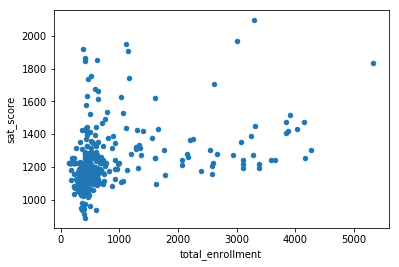

In [224]:
combined.plot.scatter("total_enrollment","sat_score")

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further. We will take rows where total_enrollment is under 1000 and sat_score is under 1000 and assign them to low_enrollment dataset.

In [320]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]
print(low_enrollment["School Name"])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


By doing some reaserch on these school, we discover that they are made for English language learners(ELLs). ELLs, a broad term that refers to students with limited English proficiency, are a diverse group from many different states and native language backgrounds. The educational experiences of ELLs also vary greatly across the country, as states and schools differ in how to identify ELL students and in how to teach them. Regardless of approach, ELLs represent a growing part of the U.S. student body.

This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, let's plot out ell_percent vs sat_score.

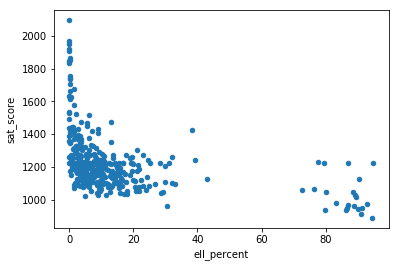

In [227]:
combined.plot.scatter("ell_percent","sat_score")

It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there's still the cluster of schools that have very high ell_percent values and low sat_score values. This cluster represents the same group of international high schools we investigated earlier.

In order to explore this relationship, we'll want to map out ell_percent by school district. The map will show us which areas of the city have a lot of English language learners.

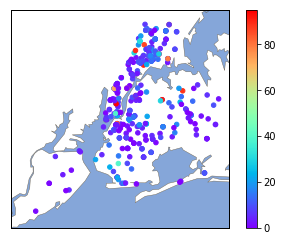

In [321]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
a=m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True,c=combined["ell_percent"],cmap="rainbow")
plt.colorbar(a)
plt.show()

From the map above, we can see that school density seems to be highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island. It looks like uptown Manhattan and parts of Queens have a higher ell_percent, but we can't be sure due to the number of schools. One way to make very granular statistics easier to read is to aggregate them. In this case, we can aggregate by district, which will enable us to plot ell_percent district-by-district instead of school-by-school.

In [245]:
import numpy

districts=combined.groupby("school_dist").agg(numpy.mean)

districts.reset_index(inplace=True)

Now that we've taken the means of all of the columns, we can plot out ell_percent by district. Not only did we find the mean of ell_percent, but we also took the means of the lon and lat columns, which will give us the coordinates for the center of each district.

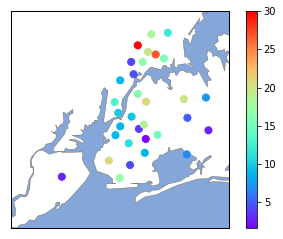

In [317]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="rainbow")
plt.colorbar()
plt.show()

# Plotting survey correlations

There are several fields in combined that originally came from a survey of parents, teachers, and students. Let's make a bar plot of the correlations between these fields and sat_score.

In [323]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

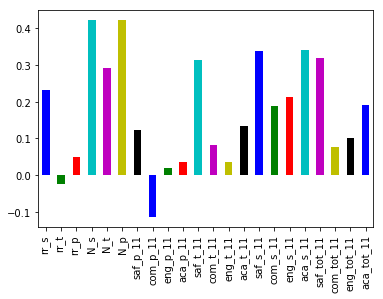

In [264]:
%matplotlib inline
my_colors=['b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y','k','b']
combined.corr()["sat_score"][survey_fields].plot.bar(color=my_colors)


On the last screen, we notice that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score. On this screen, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores. 

# Exploring safety

Let's Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.

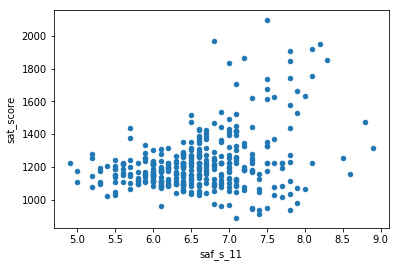

In [324]:
combined.plot.scatter("saf_s_11", "sat_score")

Write up your conclusions about safety and SAT scores in a Markdown cell.

It seems to have a raw correlation between safety and SAT scores. None of high schools having a safety score under 6.7/20 have their mean SAT score above 1600. That means that low security in high school prevents high school students from having excellent scores at SAT exam.

# Plotting safety

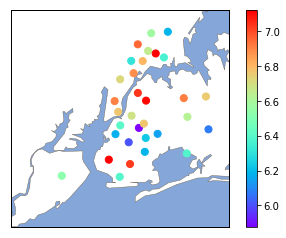

In [299]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="rainbow")
plt.colorbar()
plt.show()

Brooklyn clearly has the most districts with low security ratings for high schools. Brooklyn high school students are therefore less likely to have high SAT scores.

# Racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

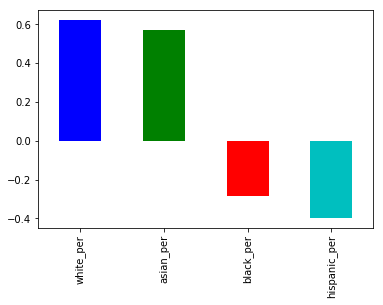

In [203]:
my_colors=['b', 'g', 'r', 'c']
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar(color=my_colors)

High schools with large proportions of white or asian students score better than others. Worse, high schools where black and hispanic communities are highly represented tend to get poor results. Let's take a closer look at Hispanic students.

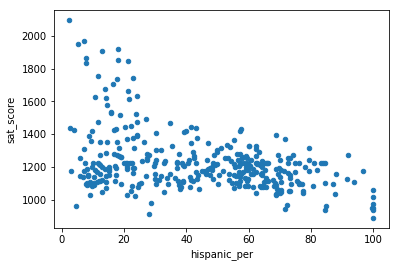

In [302]:
combined.plot.scatter("hispanic_per", "sat_score")

The observations in the figure above confirm those of the correlation. The higher the proportion of Hispanic students, the lower the test results. There appears to be a high school group with proportions of Hispanic students above 95% and very low SAT scores. Let's analyze these establishments.

In [308]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are special schools for people who speak only Spanish, often children of immigrants. This language blockage explains the bad SAT scores these schools have.

In [309]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


However, people of Spanish origins have trouble to enter the best schools of Science and Technology of New York according to the results above.

# Gender differences in SAT Scores

Let's explore the difference in performance between girls and boys in this test.

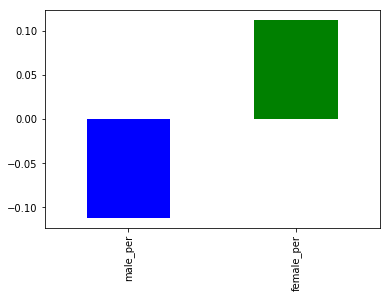

In [310]:
gender_fields = ["male_per", "female_per"]
my_colors=['b', 'g']
combined.corr()["sat_score"][gender_fields].plot.bar(color=my_colors)

Correlations are very low between gender and test scores. On the other hand, girls do better than boys. Let's analyze in more detail the observations in women.

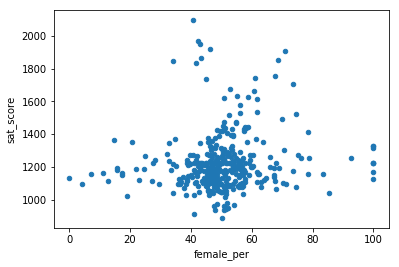

In [311]:
combined.plot.scatter("female_per", "sat_score")

As mentioned previously, there is no great trend that emerges. However, there is a group of high schools with a women majority and fairly high SAT scores. Below is the list of the names of these high schools.

In [313]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


While searching the net, one can realize that these are high schools teaching disciplines such as art, music etc. This is not surprising, since it well known that women Outnumber men at art schools.

# Conclusion

We've gone from having several messy sources to one clean, combined, dataset that's ready for analysis. In more details we've:

* Handled files with different formats and columns
* Handled missing values
* condenseted data sets
* Used different types of merges
* Combined the datasets
* Analysed the data

The cleaned data set obtained, we started our analysis! 

Along the way, we've learned that:

* Larger schools tend to do better on the SAT.
* There is a small gender difference. Women doing better than men on the SAT.
* There is significant racial inequality in SAT scores.
* School safety is a major factor to excel on the SAT.
* Schools with large proportion of students with limited English proficiency do bad on the SAT. 


### *To go further*

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:*

* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools. If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.